### Analyse von Herzfrequenzdaten

Der folgende Code basiert auf einer Vorlage zum Seminar "physiological data analysis for educational technologies" (WiSe 2016/17) von Yingding Wang der LMU München.
Für jede Datei mit Herzfrequenzdaten wird ein Objekt der Klasse HR_analysis erstellt, das Informationen über die Rohdaten, die dazugehörigen Zeitstempeln, in 10-Minuten segmentierte Daten mit zugehörigem Zeitstempel enthält und zudem die Daten in einem vorgegebenen Zeitrahmen (z.B. nur Daten von 8-10 Uhr) anhand von Zeitstempeln ausgeben kann.

Die Visualisierungsmethoden wurden zudem basierend auf Christian Lemkes Code programmiert.

Eine Anleitung bzw. ein Beispiel zur Verwendung der implementierten Methoden findet sich am Ende der Datei.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import datetime as dt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import OldScalarFormatter, ScalarFormatter

# enable matplotlib inline codes
%matplotlib auto
#%matplotlib notebook
#%matplotlib nbagg
%matplotlib inline

Using matplotlib backend: Qt5Agg


In [2]:
class HR_analysis():
    def __init__(self, filename):
        """
        self.hrRaw => raw data
        self.intTimestampRaw => timestamp data
        self.segments => segmented HR data
        self.segments_label => labels of segmented HR data (segmented timestamps)
        self.segments_range => defined range of segmented data (reseted after use)
        
        """
        self.start = 0
        self.end = -1
        
        # Get the current working directory
        currentDir=os.getcwd()

        heartRateFile = os.path.abspath(os.path.join(currentDir,'dataSource',filename))
        if os.path.exists(heartRateFile):
            #print('Oberserving HeartRateFile Path is:\n%s' %(heartRateFile))
            pass
        else:
            raise Exception('File %s \n does not exist!' %(heartRateFile))
            
        hrHeader, hrContent = self.parseCSV(heartRateFile, 'utf-8') # with default windows encoding

        #print(hrHeader)
        #print('The Format of single HR Data: ', hrContent[0])
        #print("Loaded No. of Heart Rate Raw Data is: %d" %(len(hrContent)))

        # The timestamp in data sets are utc timestamps
        hrRaw = [heartrate for timestamp, heartrate in hrContent]
        timestampRaw = [dt.datetime.fromtimestamp(int(timestamp)/1000) for timestamp, heartrate in hrContent]

        #print(len(hrRaw))
        #print(len(timestampRaw))
        #print('HR Data begins at: ',timestampRaw[0])
        #print('HR Data stops at: ',timestampRaw[-1])
        #print(type(timestampRaw[0]))
        
        #current date timestamp
        curDateTS = self.getBeginTimestamp(timestampRaw[0]) 
        #print("timestamp of current Date: " , curDateTS)

        # list of timestamps saved in int
        self.intTimestampRaw = [int(int(timestamp)/1000) for timestamp, heartRate in hrContent]
        
        self.date = timestampRaw[0].strftime("%d.%m.%y")
        
        # segments is a dictionary with segment timestamp as key, 
        # and all heart rate values of the segment is saved as value
        # in the segment dictionary
        self.segments = self.segmentingDate(self.intTimestampRaw, hrRaw, curDateTS)
        self.segments_labels = []
        for label in self.segments.keys():
            self.segments_labels.append(int(label))
        # in place sorting
        list.sort(self.segments_labels)     

        #print("The number of segments is: ", len(self.segments))
        
        self.hrRaw = [int(value) for value in hrRaw]
            
    def parseCSV(self, file, coding='utf-8'):
        # a possible encoding can be 'iso-8859-15'
        with open(file, 'r', encoding=coding) as csvfile:
            reader = csv.reader(csvfile)
            content = list(reader)
            header = content.pop(0) # remove first header
        return header, content

    def getBeginTimestamp(self, datetime):
        """
        this method returns the timestampe of the day by the given datetime.
        If the given datetime is 2016-10-05 01:29:20
        this method returns the timestamp of 2016-10-05 00:00:00
        """
        # extract the date string from the given datetime object
        str_current_date = dt.datetime.strftime(datetime, '%Y-%m-%d')
        # print("Current Observed Date: ",str_current_date)
        # convert the extracted date string to datetime object
        currentDate = dt.datetime.strptime(str_current_date, '%Y-%m-%d')
        # get the utc timestamp of the date string of the given datetime object
        int_ts_currentDate = int(dt.datetime.timestamp(currentDate))
        return int_ts_currentDate;

    def segmentingDate(self, intTimestampRaw, hrRaw, curDateTS): 
        """
        this method make 10 minutes segments from heart rate raw data
        """
        segments = {}
        deliminator = 10 * 60
        segment_id = 0
        for id in range(len(intTimestampRaw)):
            timestamp = intTimestampRaw[id]
            heartrate = int(hrRaw[id])
            segment_id = (timestamp - curDateTS) // deliminator
            segment_label = segment_id * deliminator + curDateTS
            segments.setdefault(segment_label,[]).append(heartrate)
        return segments
    
    def set_range(self, start, end):
        #self.segments_range = self.segments_labels[start:end]
        self.start = start
        self.end = end
    
    def reset_range(self):
        #self.segments_range = []
        self.start = 0
        self.end = -1

## Plotting functions

In [3]:
def ploting(xvals, yvals, xlabel_str, ylabel_str, title, style):
    """
    creates a plot
    """
    # close all old plots
    plt.close("all")
    # plotting
    plt.plot(xvals, yvals, style)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)    
    plt.title(title)
    # show the grid line/ help line in plot
    plt.grid(True)
    #plt.legend(loc='upper right')
    #plt.axis([0, 210, 0, 0.04 ])
    #plt.figure(figsize=[9,6])
    plt.show()

In [4]:
# Display segments
def displaySegment(idx, segments, segments_labels):
    segment_label = segments_labels[idx]
    print("ploting segement with label: ", dt.datetime.fromtimestamp(segment_label))
    segment = segments[segment_label]
    # print(segment)
    ploting(range(len(segment)),segment, "time line", "heart rate (BPS)", "segment "+ str(segment_label), 'b-')

In [5]:
def plotting_feature(featureName, hr_data, date_type=True):
    
    featureValues, labelValues, unit = get_feature_values(hr_data, featureName, date_type)
    title = featureName + " to datetime" if date_type else featureName
    ploting(labelValues, featureValues, 'datetime', featureName, title, 'g-')

In [6]:
def pretty_plotting(featureName, hr_data, span=[], date_type=True, plot_type= 'ro-'):
    
    if span:
        start, end = span
        hr_data.set_range(start,end)
        featureValues, labelValues, unit = get_feature_values(hr_data, featureName, date_type)

    else:
        featureValues, labelValues, unit = get_feature_values(hr_data, featureName, date_type)

    fig, ax = plt.subplots()
    fig.set_size_inches(15,3.5)
    
    if date_type:
        ax.plot_date(labelValues, featureValues,plot_type, label=featureName)
    else:
        ax.plot(labelValues, featureValues, plot_type, label=featureName)

    handles, ax_labels = ax.get_legend_handles_labels()
    ax.legend(handles, ax_labels)

    if date_type:
        myFmt = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(myFmt)
        xlabel = 'time [hh:mm]'
        title = featureName + ' ' + str(hr_data.date)
    else:
        xlabel = ''
        title = featureName

    if featureName == "pRR50":
        ax.set_ylim([0,25])
    ax.set_xlim([labelValues[0], labelValues[-1]])
    plt.xlabel(xlabel)
    plt.ylabel(featureName + ' [' + unit + ']')
    plt.title(title)
    plt.show()
    fig.savefig(title + ".jpg")
    hr_data.reset_range()

In [7]:
def mean_plotting(featureName, hr_data, span=[], date_type=True, sd=False, sd_type=""):
    if span:
        start, end = span
        hr_data.set_range(start, end)
        featureValues, labelValues, unit = get_feature_values(hr_data, featureName, date_type)

        labelValuesMin = [60/np.min(hr_data.segments[segment_label]) 
                          for segment_label in hr_data.segments_labels[hr_data.start:hr_data.end]]
        labelValuesMax = [60/np.max(hr_data.segments[segment_label]) 
                          for segment_label in  hr_data.segments_labels[hr_data.start:hr_data.end]]
    else:
        featureValues, labelValues, unit = get_feature_values(hr_data, featureName, date_type)
        labelValuesMin = [60/np.min(hr_data.segments[segment_label]) 
                          for segment_label in hr_data.segments_labels[hr_data.start:hr_data.end]]
        labelValuesMax = [60/np.max(hr_data.segments[segment_label]) 
                          for segment_label in  hr_data.segments_labels[hr_data.start:hr_data.end]]
        
    fig, ax = plt.subplots()
    fig.set_size_inches(15,3.5)
    
    if sd:
        sd_values, _, _ = get_feature_values(hr_data, 'SD' + featureName[-2:], date_type)
        
        if sd_type=="fill":
            mean_plus_sd = [featureValues[i] + sd_values[i] for i in range(len(sd_values))]
            mean_minus_sd = [featureValues[i] - sd_values[i] for i in range(len(sd_values))]

            ax.fill_between(labelValues, featureValues, mean_plus_sd, color='r', label='SD' + featureName[-2:] +' error')
            ax.fill_between(labelValues, featureValues, mean_minus_sd, color='r')

        else:
            ax.errorbar(labelValues,featureValues,sd_values, ecolor='r', label='SD' + featureName[-2:] +' error')
    
    if date_type:
        ax.plot_date(labelValues, labelValuesMax, 'b--', label='Min' + featureName[-2:] +' & Max' + featureName[-2:])
        ax.plot_date(labelValues, featureValues, 'bo-', label=featureName)
        ax.plot_date(labelValues, labelValuesMin, 'b--')
    else:
        ax.plot(labelValues, labelValuesMax, 'b--', label='Min' + featureName[-2:] +' & Max' + featureName[-2:])
        ax.plot(labelValues, featureValues, 'bo-', label=featureName)
        ax.plot(labelValues, labelValuesMin, 'b--')
        
    
    handles, ax_labels = ax.get_legend_handles_labels()
    ax.legend(handles, ax_labels)

    if date_type:
        myFmt = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(myFmt)
        xlabel = 'time [hh:mm]'
        title = featureName + ' ' + str(hr_data.date)
    else:
        xlabel = ''
        title = featureName
    
    if featureName == "pRR50":
        ax.set_ylim([0,25])
    ax.set_xlim([labelValues[0], labelValues[-1]])
    plt.xlabel(xlabel)
    plt.ylabel(featureName + ' [' + unit + ']')
    plt.title(title)
    plt.show()
    
    fig.savefig(title + ".jpg")
    
    hr_data.reset_range()

## Feature Configuration

In [8]:
def get_feature_values(hr_data, featureName, date=True):
        
    all_ts_needed = ["RR", "HR"]
    
    if isinstance(hr_data, tuple) and not date:
        labelValues = hr_data[0]
        featureValues = call_feature_function(hr_data[1], featureName)
    else:
        if featureName in all_ts_needed:
            label_base = hr_data.intTimestampRaw 
            hr_base = {label_base[i]: [hr_data.hrRaw[i]] for i in range(len(label_base))}
        else:
            label_base = hr_data.segments_labels
            hr_base = hr_data.segments

        if hr_data.start != 0 or hr_data.end != -1:
            start = hr_data.start
            end = hr_data.end
        else:
            start = 0
            end = -1

        labelValues = [dt.datetime.fromtimestamp(segment_label) for segment_label in label_base[start:end]]
        
        featureValues = []
        for segment_label in label_base[start:end]:
            featureValues.extend(call_feature_function(hr_base[segment_label], featureName))
    

    assert len(featureValues) == len(labelValues)
    
    # define measure unit for visualization.
    if featureName.startswith("pNN") or featureName.startswith("pRR"):
        unit = '%'
    elif featureName == "CVRR" or featureName == "CVNN":
        unit = ''
    elif featureName.endswith("RR") or featureName.endswith("NN") or featureName == "RMSSD":
        unit = 's'
    elif featureName.endswith("HR"):
        unit = 'bps'
    elif featureName == "ApEn":
        unit = ''
    else:
        unit = '<unk>'
    
    return featureValues, labelValues, unit

In [9]:
def call_feature_function(segment, featureName):
    if featureName == "" or featureName == "HR":
        return segment   
    elif featureName == "meanHR" or featureName == "MeanHR":
        return [meanHR(segment)]
    elif featureName == "SDHR":
        return [SDHR(segment)]
    
    elif featureName == "RR":
        return RR_s(segment)
    elif featureName == "meanRR" or featureName == "MeanRR":
        return [meanRR(segment)]
    elif featureName == "SDRR":
        return [SDRR(segment)]
    elif featureName == "CVRR":
        return [CVRR(segment)]
    elif featureName == "pRR50":
        return [pRR50(segment)]
    
    elif featureName == "NN":
        return RR(segment)
    elif featureName == "meanNN" or featureName == "MeanNN":
        return [meanRR(segment)]
    elif featureName == "SDNN":
        return [SDRR(segment)]
    elif featureName == "CVNN":
        return [CVRR(segment)]
    elif featureName == "pNN50":
        return [pRR50(segment)]

    elif featureName == "RMSSD":
        return [RMSSD(segment)]
    elif featureName == "ApEn":
        return [ApEn(segment)]

In [10]:
def meanHR(segment):
    return np.mean(segment)

def SDHR(segment):
    return np.std(segment)

def RR_ms(segment):
    return [60000/hrValue for hrValue in segment]

def RR_s(segment):
    return [60/hrValue for hrValue in segment]

def RR(segment):
    return RR_s(segment)

def SDRR(segment):
    return np.std(RR(segment))

def meanRR(segment):
    return np.mean(RR(segment))

def RMSSD(segment):
    RR = RR_s(segment)
    tmp = [(RR[i+1]-RR[i])**2 for i in range(len(RR)-1)]
    return np.sqrt(np.mean(tmp)) if tmp else 0

def ApEn(segment):
    U = segment
    m= 2
    r = 3
    
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

def CVRR(segment):
    return SDRR(segment)/float(meanRR(segment))

def pRR50(segment):
    if len(segment) <= 1:
        return 0
    
    RR50_count = 0
    RR = RR_s(segment)
    for i in range(len(RR)-1):
        if abs(RR[i+1]-RR[i])>0.05:
            RR50_count+=1
    
    # pRR50 = RR50_count/RR_count * 100 (in %)
    return (RR50_count/float(len(RR)-1))*100

def pRR50_ms(segment):
    
    if len(segment) <= 1:
        return 0
    
    RR50_count = 0
    RR = RR_ms(segment)
    for i in range(len(RR)-1):
        if abs(RR[i+1]-RR[i])>50:
            RR50_count+=1
    
    # pRR50 = RR50_count/RR_count * 100 (in %)
    return (RR50_count/float(len(RR)-1))*100

In [11]:
def get_segment_number(featureName, hr_data, search_time):
    
    assert search_time >= 0 and search_time < 24
    
    all_ts_needed = ["RR", "HR"]
    
    if featureName in all_ts_needed:
        label_base = hr_data.intTimestampRaw
    else:
        label_base = hr_data.segments_labels
    
    d = dt.datetime.fromtimestamp(label_base[0]).date()
    t = dt.time(search_time)
    searched_date = dt.datetime.combine(d, t)
    #print(searched_date)
    
    for i in range(len(label_base)):
        label = label_base[i]
        #print(dt.datetime.fromtimestamp(label))
        if dt.datetime.fromtimestamp(label) >= searched_date:
            return i
    

## Main program

Beispiel zur Verwendung der Methoden

Mit Angabe des Dateinamens können die Daten eingelesen werden und pro Tag ein Objekt erstellt werden

In [12]:
# Variante 1:
# day09 = HR_analysis("heartrate_2017-01-09.csv")
# day10= HR_analysis("heartrate_2017-01-10.csv")
# day11 = HR_analysis("heartrate_2017-01-11.csv")
# day12 = HR_analysis("heartrate_2017-01-12.csv")
# day16 = HR_analysis("heartrate_2017-01-16.csv")
# days = [day09, day10, day11, day12, day16]

# Variante 2:
day_list = ["2017-01-09", "2017-01-10", "2017-01-11", "2017-01-12", "2017-01-14", "2017-01-16"]
days = [HR_analysis("heartrate_" + day + ".csv") for day in day_list]

Für jeden Tag werden nun die Daten geplottet. Hierzu kann ein Zeitrahmen (hier: 8-22 Uhr) angegeben werden, ansonsten werden einfach alle Daten des Tages verwendet.

Unter Angabe des zu visualisierenden Merkmals wird die korrektion Funktion (siehe Feature Configuration) ausgewählt.

Für Mittelwertsdarstellungen mit Min/Max-Rahmen wird die Funktion mean_plotting verwendet, ansonsten liefert pretty_plotting einen schön beschrifteten Plot bei dem mit plot_type die Farbe (b=blau, r=rot, g=grün) und die Art der Linie (hier: -) ausgewählt werden kann.

Die Plots werden bei Generierung zusätzlich unter "[merkmalsname] [dd.mm.yy].jpg" abgespeichert.

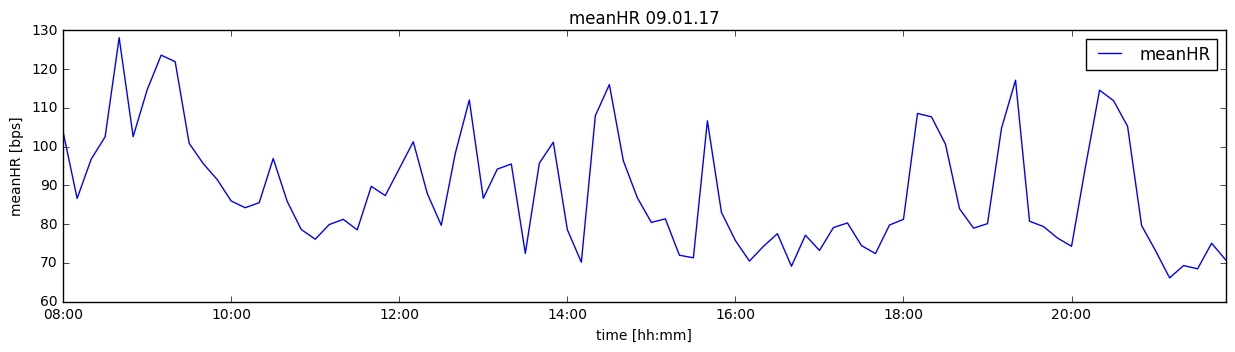

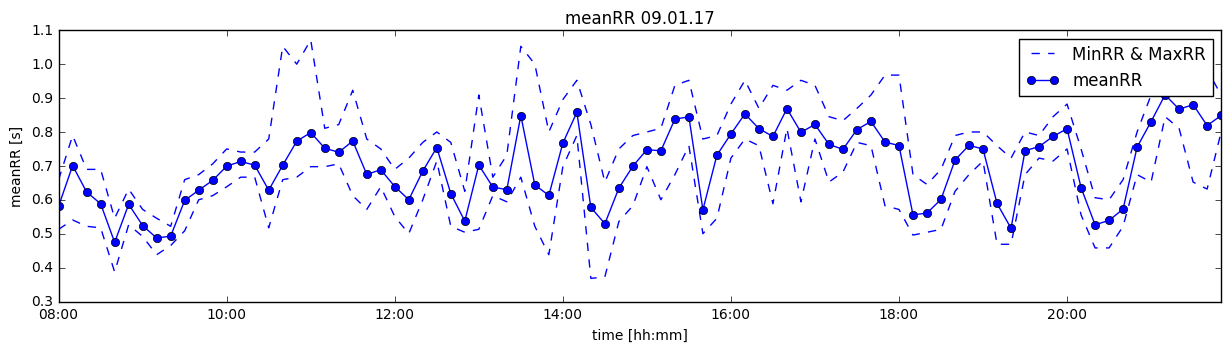

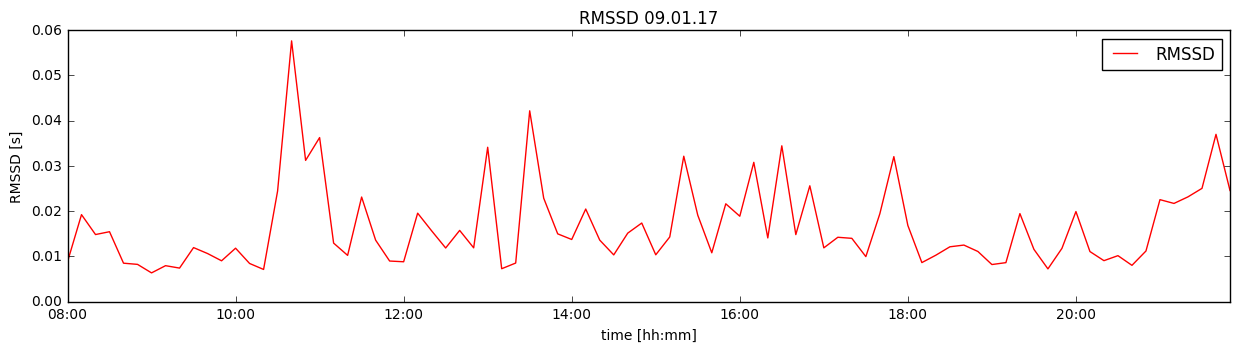

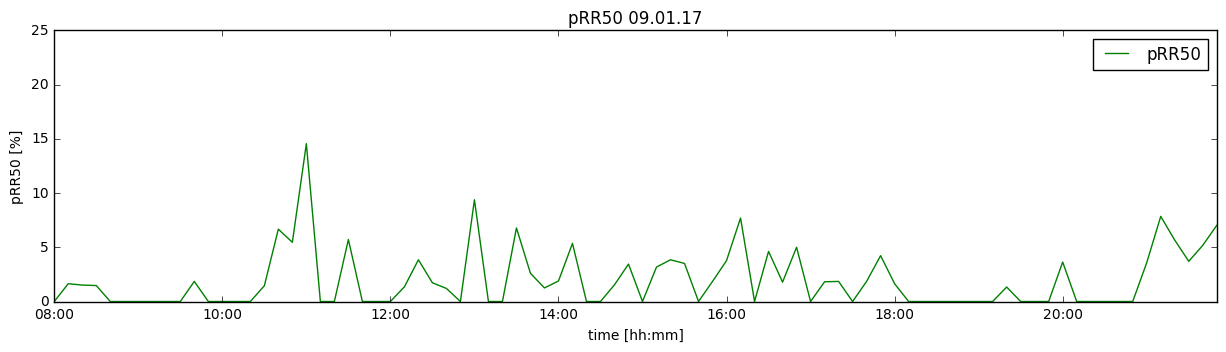

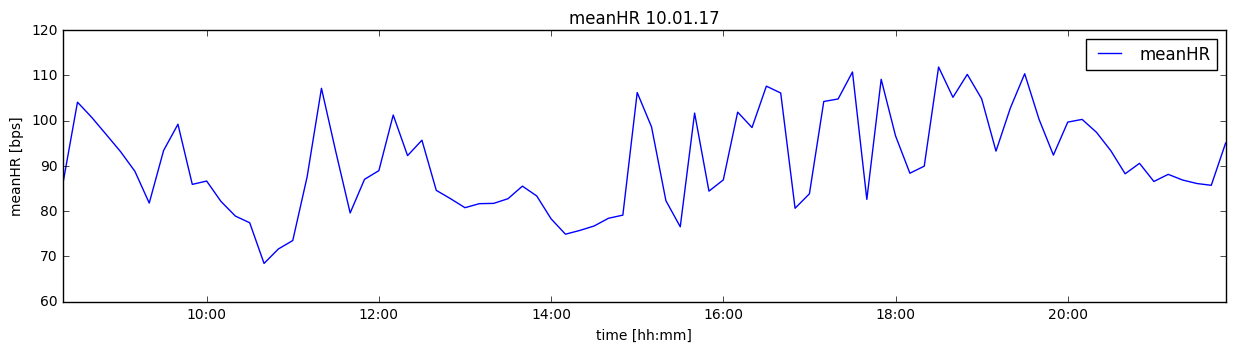

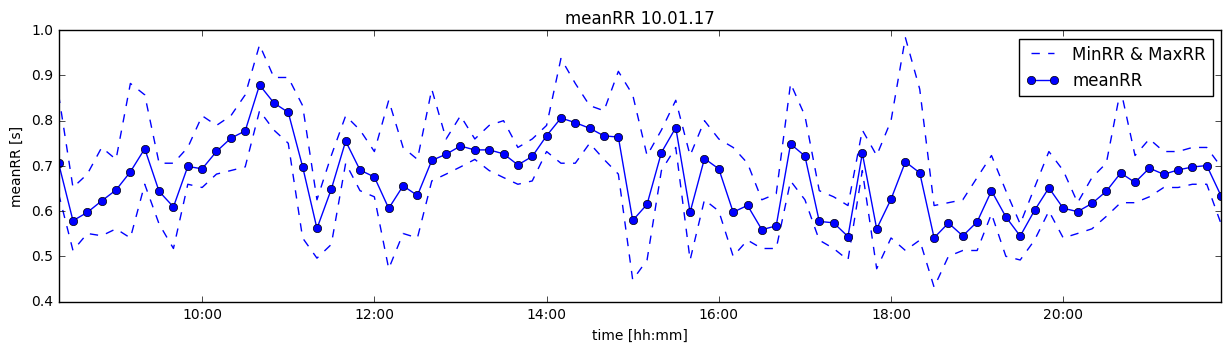

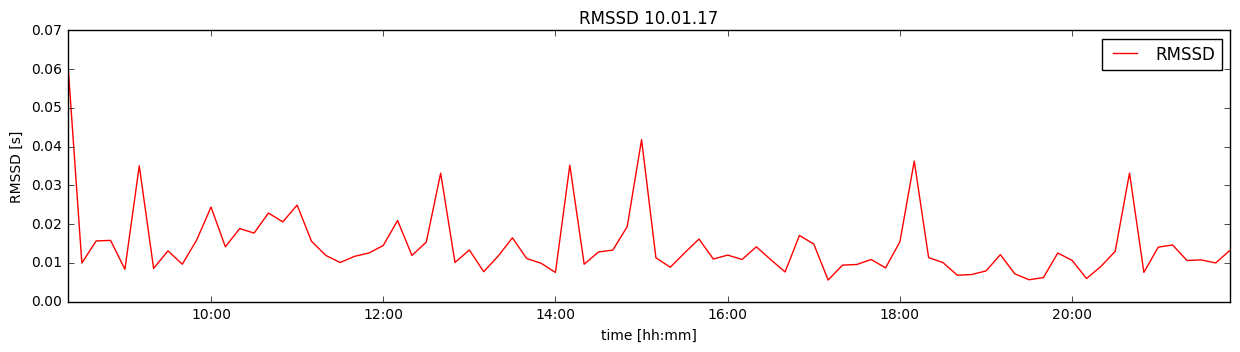

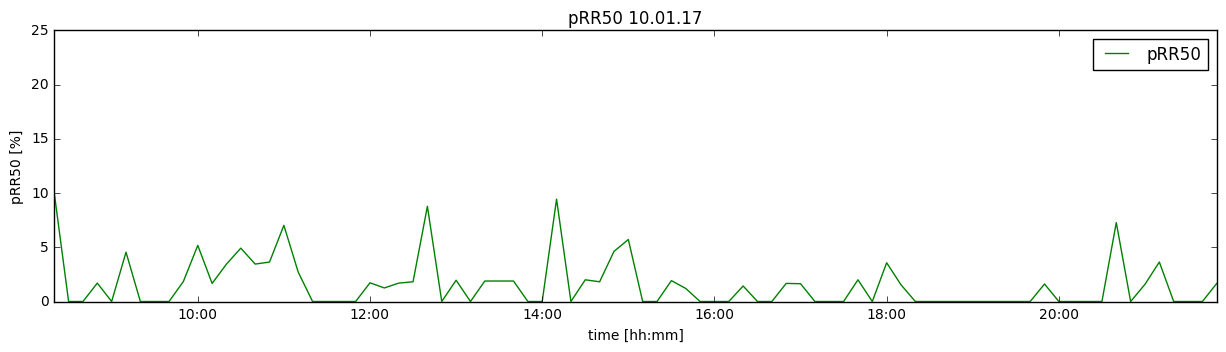

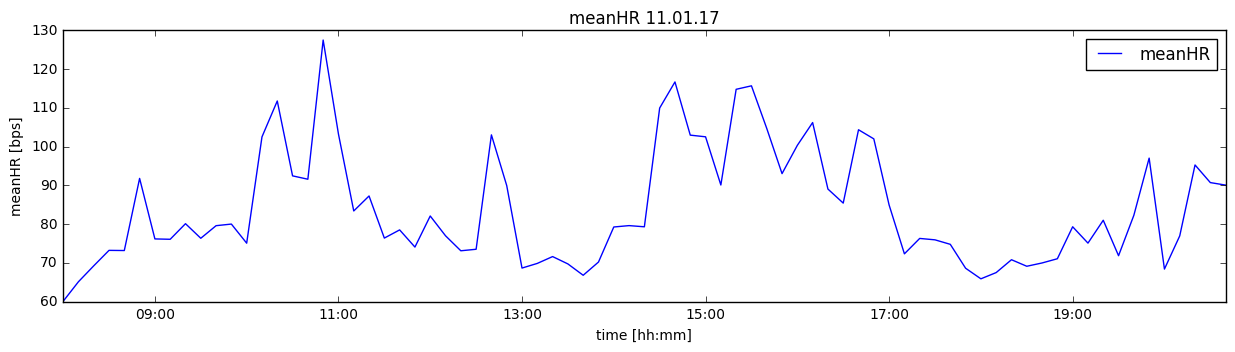

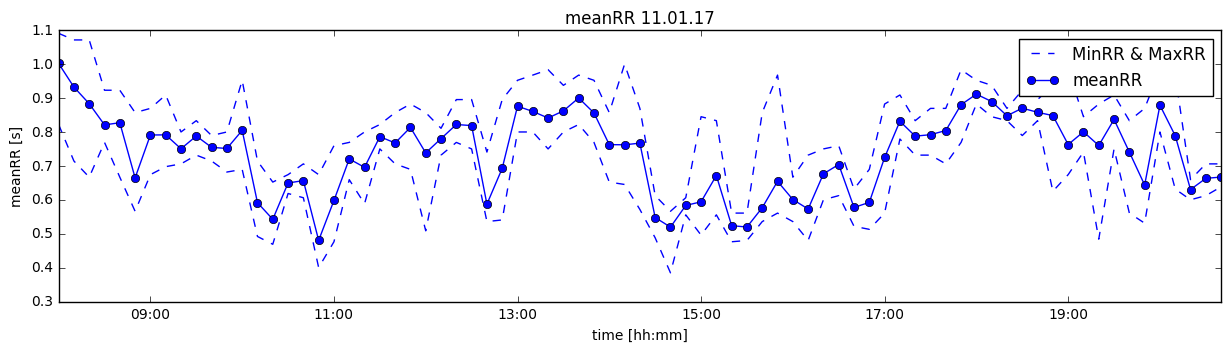

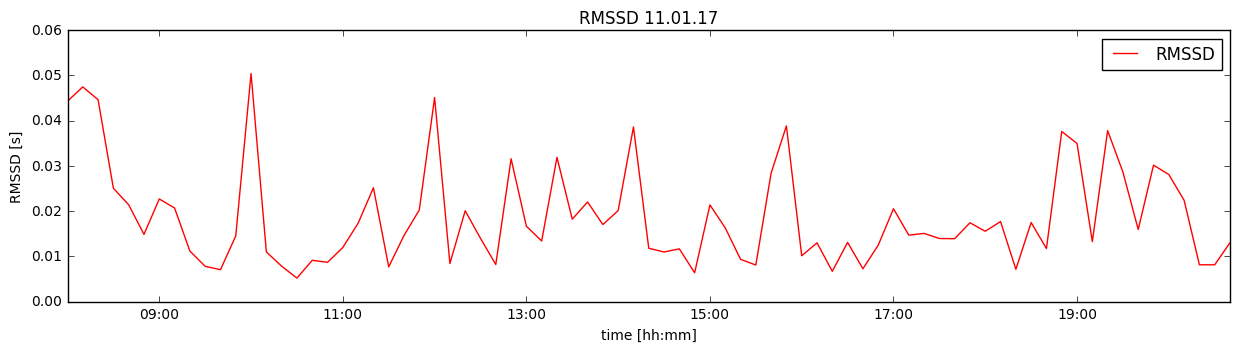

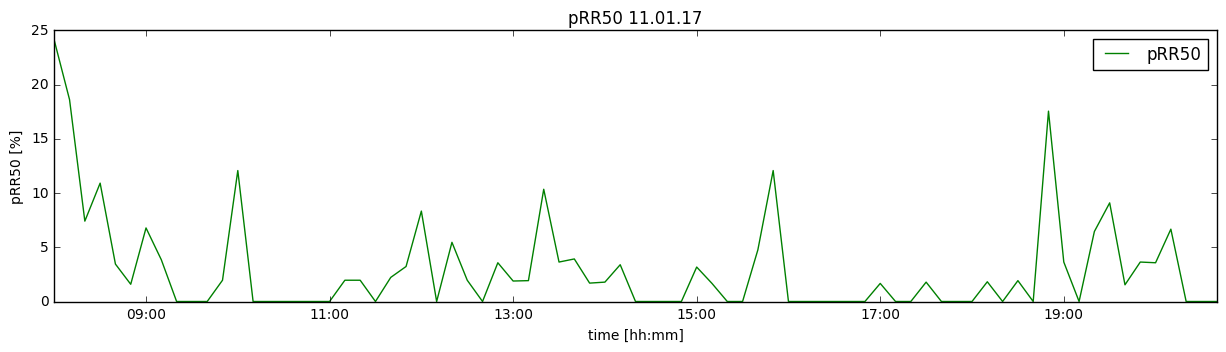

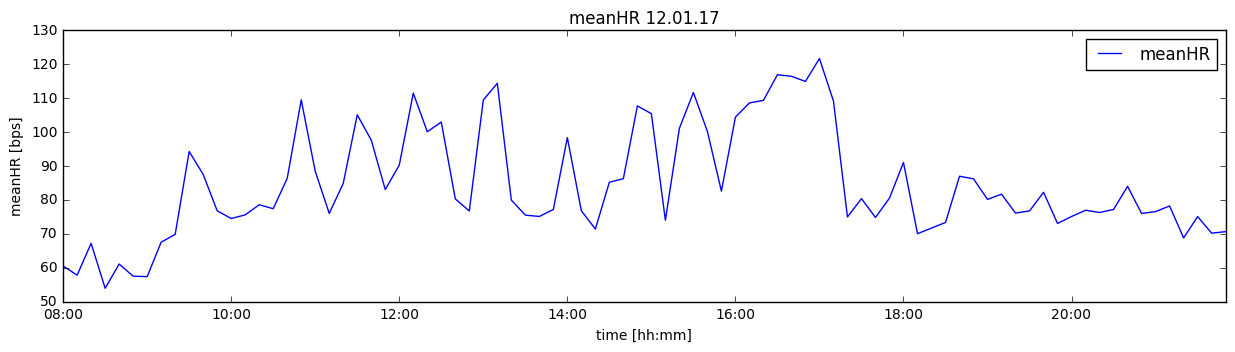

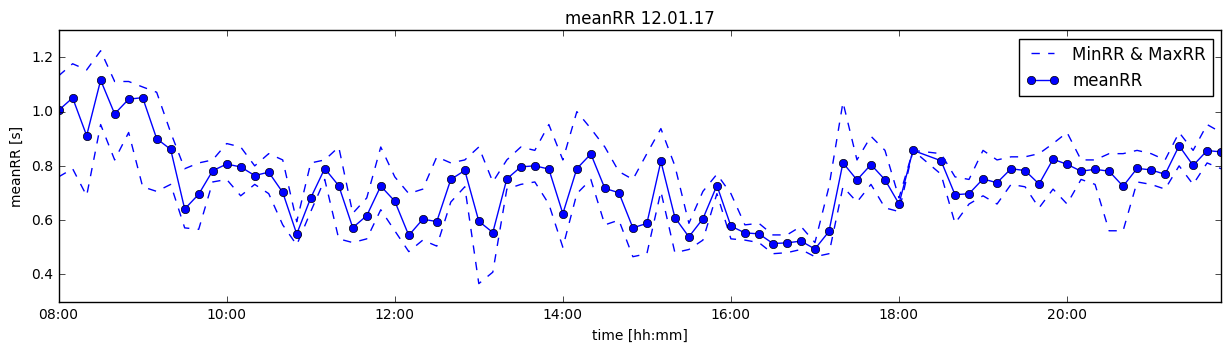

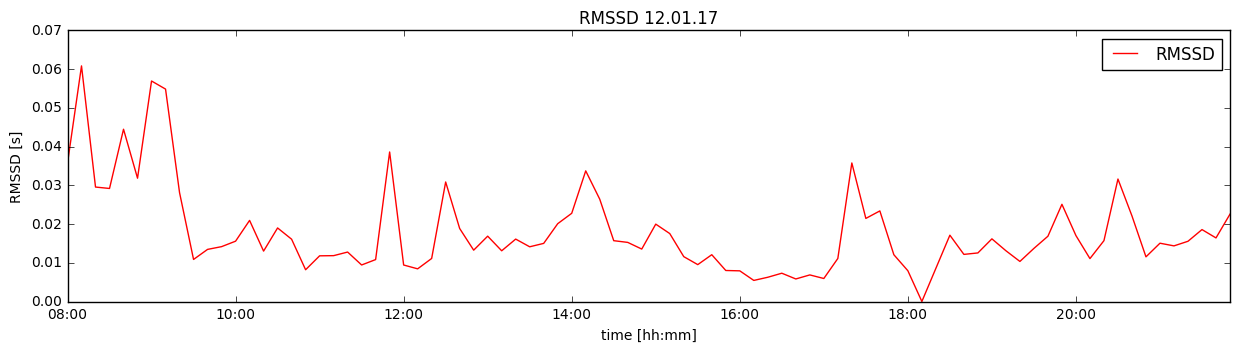

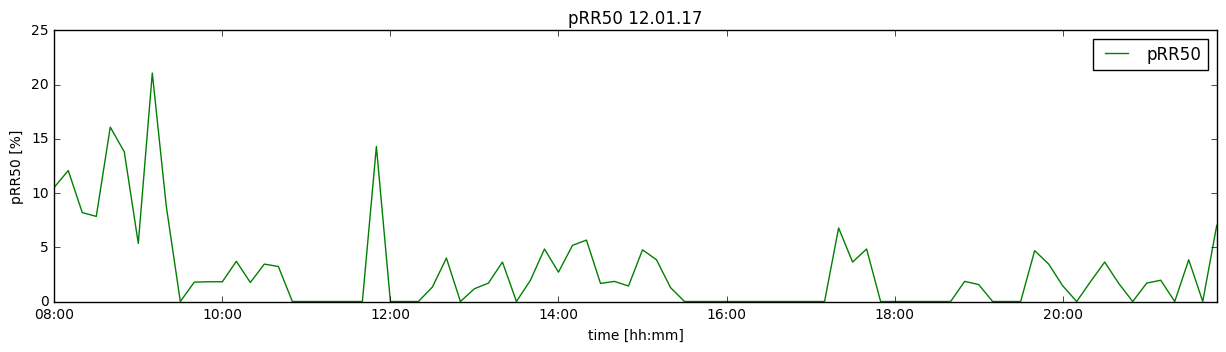

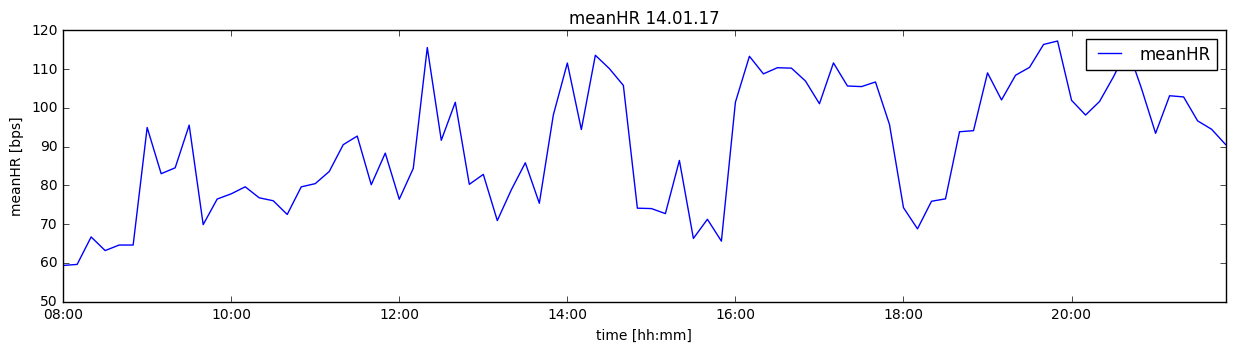

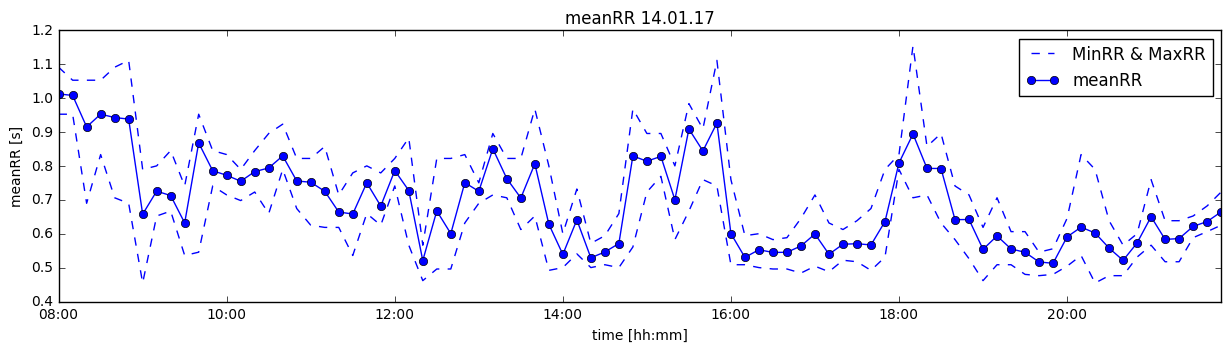

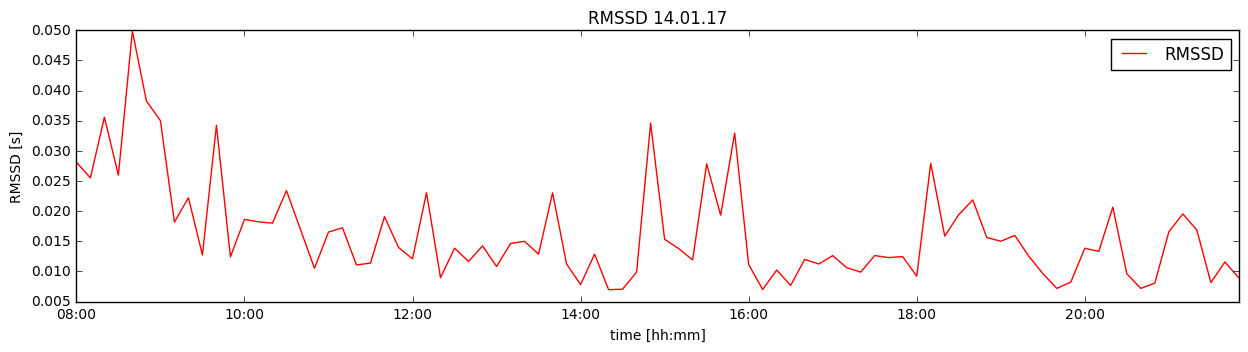

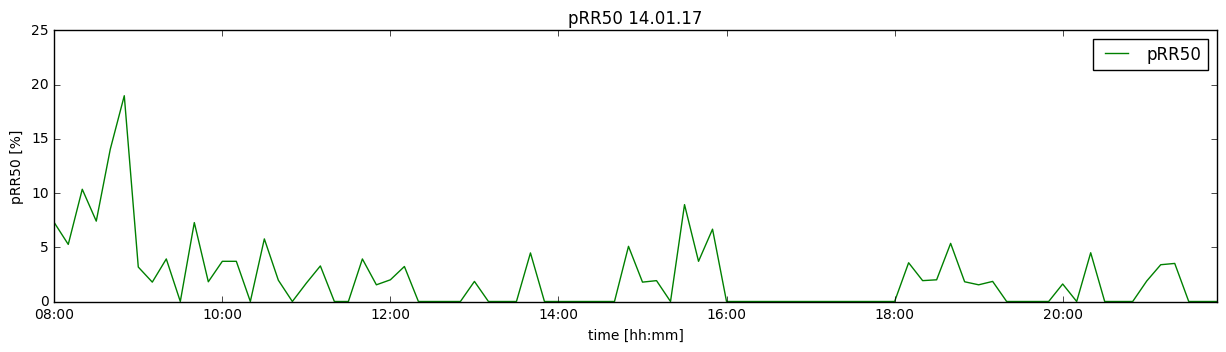

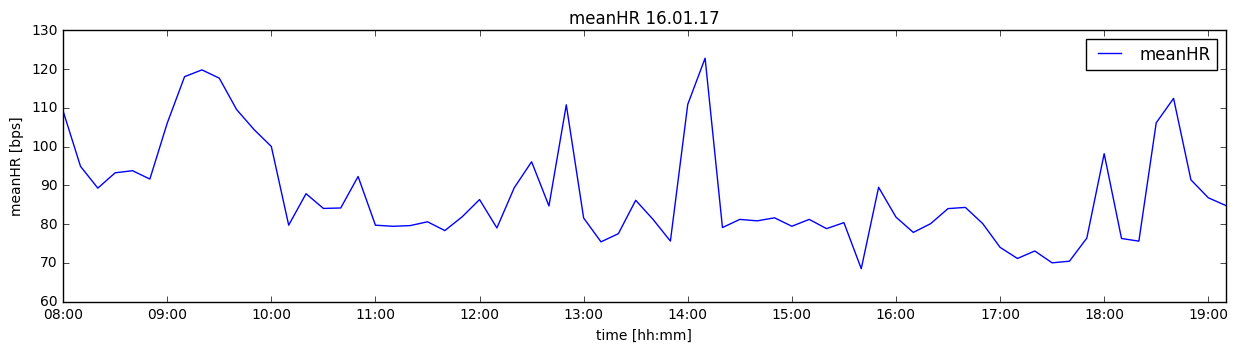

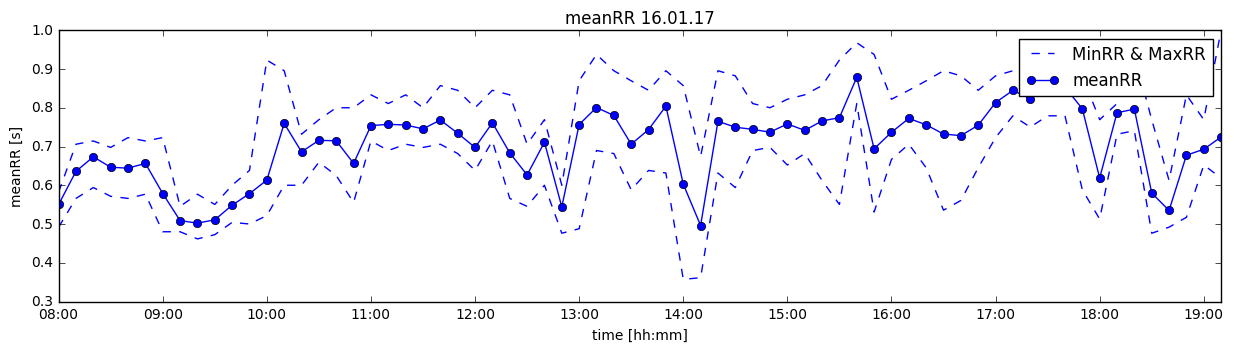

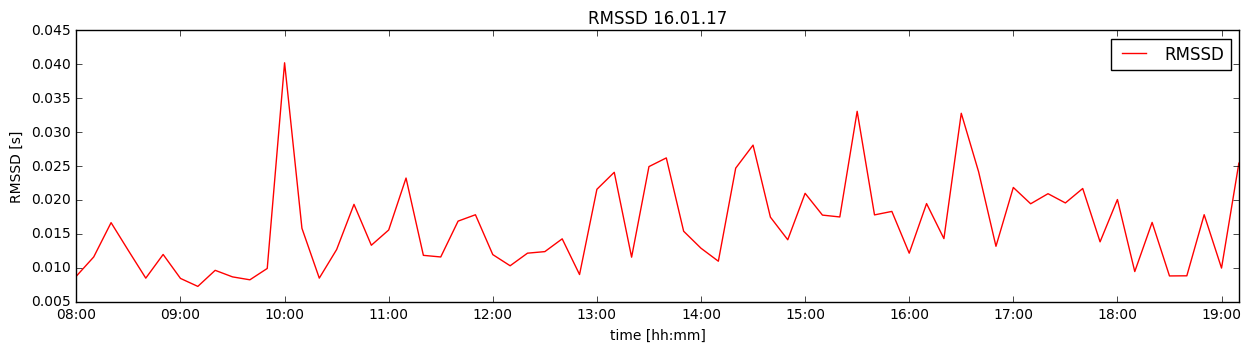

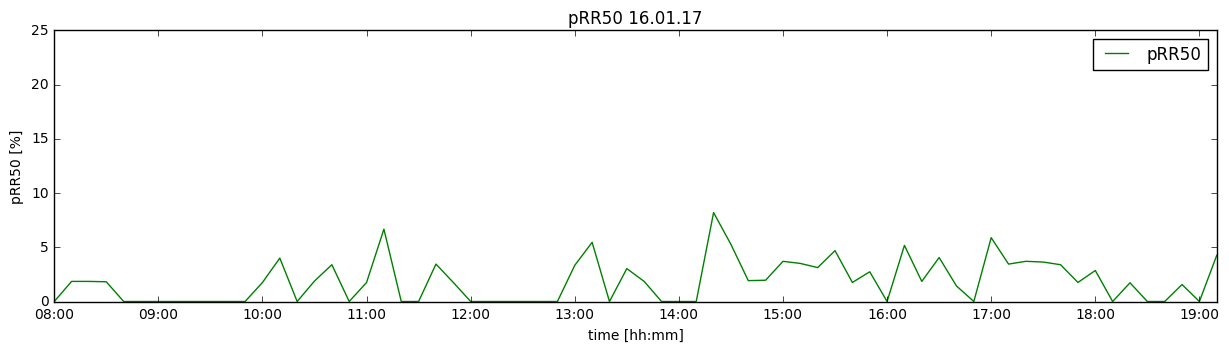

In [13]:
for day in days:
    span = [get_segment_number("meanHR", day, 8), get_segment_number("meanHR", day, 22)]
    pretty_plotting("meanHR", day, span=span, plot_type="b-")
    mean_plotting("meanRR", day, span=span)
    pretty_plotting("RMSSD", day, span=span, plot_type="r-")
    pretty_plotting("pRR50", day, span=span, plot_type="g-")

Zudem wird basierend auf den Rohdaten (hrRaw) der pRR50-Wert für den kompletten Tag berechnet und ausgegeben.

In [14]:
for day in days:
    print("pRR50 of {0}:\t{1}".format(day.date, pRR50(day.hrRaw)))

pRR50 of 09.01.17:	1.8575851393188854
pRR50 of 10.01.17:	4.294330518697226
pRR50 of 11.01.17:	4.5622512791358725
pRR50 of 12.01.17:	4.83851457602516
pRR50 of 14.01.17:	3.4262948207171315
pRR50 of 16.01.17:	1.993704092339979
